In [2]:
# ==============================================================================
# PROJECT: Kaggle Playground Series - S6E2 (Heart Disease)
# MISSION: Establishing the Baseline Model & Overcoming Encoding Hurdles
# NARRATOR: [Your Name]
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# --- STEP 1: MOUNTING THE ARMORY (Google Drive) ---
# Connecting to Google Drive to access the competition datasets.
drive.mount('/content/drive')

# --- STEP 2: LOADING THE DATA ---
# Replace these strings with your actual Google Drive file paths.
TRAIN_PATH = '/content/drive/MyDrive/Nihal Data/kaggle/S6E1 - heart/train.csv'
TEST_PATH = '/content/drive/MyDrive/Nihal Data/kaggle/S6E1 - heart/test.csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print(f"✅ Data Loaded! Training set size: {train.shape}")

# --- STEP 3: PREPARING THE BATTLEFIELD (Encoding) ---

# 1. Target Encoding: Converting 'Absence'/'Presence' to 0/1
# XGBoost requires numeric targets for classification.
target_mapping = {'Absence': 0, 'Presence': 1}
y = train['Heart Disease'].map(target_mapping)

# 2. Feature Selection
# We exclude 'id' (not a predictor) and the original 'Heart Disease' column.
features = [col for col in train.columns if col not in ['id', 'Heart Disease']]
X = train[features].copy()
X_test = test[features].copy()

# 3. Categorical Encoding: Handling text data in the features
# We iterate through 'object' columns and convert them to numeric category codes.
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category').cat.codes
    X_test[col] = X_test[col].astype('category').cat.codes

print("✅ Features and Target successfully encoded.")

# --- STEP 4: TRAINING THE CHAMPION (XGBoost) ---

# Splitting data: 80% Training, 20% Validation
# 'stratify=y' ensures both sets have the same percentage of Heart Disease cases.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initializing the XGBoost Classifier
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    tree_method='hist', # Efficient for large tabular datasets
    eval_metric='auc',
    early_stopping_rounds=50,
    random_state=42
)

# Fitting the model with the validation set to monitor for overfitting
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# --- STEP 5: THE MOMENT OF TRUTH ---

# Predicting probabilities for the validation set
val_probs = model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val, val_probs)

print(f"\n🚀 MISSION SUCCESS! Local Validation AUC: {final_auc:.5f}")

# --- STEP 6: GENERATING THE SUBMISSION ---

# Generating the final probability predictions for the Kaggle test set
test_probs = model.predict_proba(X_test)[:, 1]
submission = pd.DataFrame({'id': test['id'], 'Heart Disease': test_probs})

# Saving the output to a CSV file
submission.to_csv('submission_baseline.csv', index=False)

print("💾 Submission file saved as 'submission_baseline.csv'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data Loaded! Training set size: (630000, 15)
✅ Features and Target successfully encoded.
[0]	validation_0-auc:0.93991
[100]	validation_0-auc:0.95456
[200]	validation_0-auc:0.95534
[300]	validation_0-auc:0.95577
[400]	validation_0-auc:0.95592
[500]	validation_0-auc:0.95596
[600]	validation_0-auc:0.95597
[615]	validation_0-auc:0.95597

🚀 MISSION SUCCESS! Local Validation AUC: 0.95597
💾 Submission file saved as 'submission_baseline.csv'.


/tmp/ipython-input-328626020.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


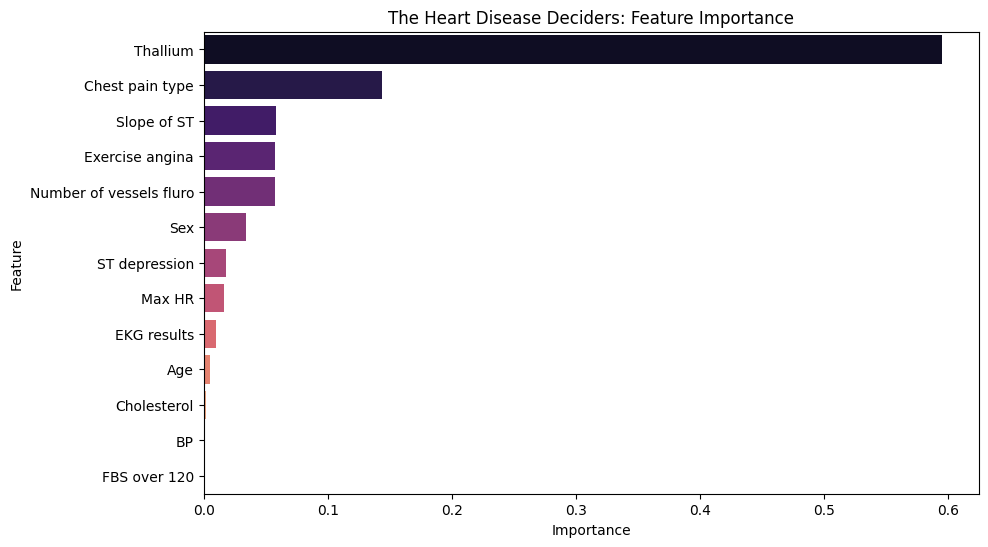

>> Analysis complete. I now know which health markers to focus.


In [4]:
# --- STEP 7: FEATURE IMPORTANCE (The X-Ray) ---
# I want to see which medical markers are driving the predictions.

import matplotlib.pyplot as plt

# Getting the importance scores
importance = model.feature_importances_
feature_names = X.columns

# Sorting them for a better visual
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('The Heart Disease Deciders: Feature Importance')
plt.show()

print(">> Analysis complete. I now know which health markers to focus.")